In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [12]:
# Step 1: Preprocess the data
# Load the dataset
data = pd.read_csv('data1.csv')
data

,Date,Price
0,2006-01-01,4000.000000
1,2006-01-02,4000.000000
2,2006-01-03,4005.000000
3,2006-01-04,4000.000000
4,2006-01-05,4000.000000
...,...,...
5996,2022-06-02,4051.000000
5997,2022-06-03,4050.000000
5998,2022-06-04,4050.333333
5999,2022-06-05,4050.666667


In [13]:
# Parse dates and set it as the index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [14]:
# Normalize the price values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Price'].values.reshape(-1, 1))

In [15]:
# Split the dataset into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [16]:
# Step 2: Train an LSTM model
# Define the input sequence length
sequence_length = 100

In [17]:
# Generate input sequences and corresponding labels
def generate_sequences(data, sequence_length):
    X = []
    y = []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

In [18]:
X_train, y_train = generate_sequences(train_data, sequence_length)
X_test, y_test = generate_sequences(test_data, sequence_length)

In [19]:
# Create an LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(sequence_length, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [20]:
# Define callbacks for early stopping and model checkpoint
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10),
    ModelCheckpoint('lstm_model.h5', save_best_only=True, verbose=1)
]

In [21]:
# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=16, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/10
294/294 [==============================] - ETA: 0s - loss: 0.0039
Epoch 1: val_loss improved from inf to 0.00100, saving model to lstm_model.h5
294/294 [==============================] - 12s 36ms/step - loss: 0.0039 - val_loss: 9.9917e-04
Epoch 2/10
293/294 [============================>.] - ETA: 0s - loss: 0.0014
Epoch 2: val_loss improved from 0.00100 to 0.00059, saving model to lstm_model.h5
294/294 [==============================] - 10s 33ms/step - loss: 0.0014 - val_loss: 5.9494e-04
Epoch 3/10
293/294 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 3: val_loss did not improve from 0.00059
294/294 [==============================] - 9s 32ms/step - loss: 0.0012 - val_loss: 6.1284e-04
Epoch 4/10
293/294 [============================>.] - ETA: 0s - loss: 0.0012
Epoch 4: val_loss improved from 0.00059 to 0.00056, saving model to lstm_model.h5
294/294 [==============================] - 10s 34ms/step - loss: 0.0012 - val_loss: 5.6479e-04
Epoch 5/10
293/294 [====

In [22]:
# Step 3: Make predictions
# Load the best saved model
best_model = Sequential()
best_model.add(LSTM(128, input_shape=(sequence_length, 1)))
best_model.add(Dense(1))
best_model.compile(loss='mean_squared_error', optimizer='adam')
best_model.load_weights('lstm_model.h5')

In [23]:
# Generate sequences for prediction
last_sequence = scaled_data[-sequence_length:]
prediction_sequences = np.expand_dims(last_sequence, axis=0)

In [40]:
# Predict next 30 days
predicted_prices = []
for _ in range(30):
    next_price = best_model.predict(prediction_sequences)
    predicted_prices.append(next_price)
    prediction_sequences = np.concatenate((prediction_sequences[:, 1:, :], next_price.reshape(1, 1, 1)), axis=1)

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 20ms/step


In [41]:
# Inverse normalize the predicted prices
predicted_prices = scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))

In [42]:
# Print the predicted prices for the next 30 days
print(predicted_prices)

[[4268.192 ]
 [4268.83  ]
 [4269.47  ]
 [4270.1113]
 [4270.754 ]
 [4271.398 ]
 [4272.044 ]
 [4272.6914]
 [4273.34  ]
 [4273.99  ]
 [4274.642 ]
 [4275.2954]
 [4275.95  ]
 [4276.607 ]
 [4277.265 ]
 [4277.925 ]
 [4278.5864]
 [4279.2495]
 [4279.9146]
 [4280.5806]
 [4281.249 ]
 [4281.919 ]
 [4282.591 ]
 [4283.2637]
 [4283.939 ]
 [4284.6157]
 [4285.2944]
 [4285.975 ]
 [4286.657 ]
 [4287.3413]]


In [44]:
# Get the dates for the predicted period
last_date = data.index[-1]
predicted_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=30)

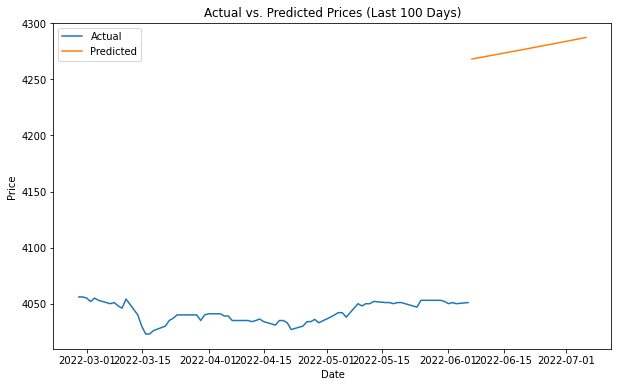

In [45]:
# Get the last 100 days of actual prices and their corresponding dates
last_100_days_actual = data.iloc[-100:]
actual_dates = last_100_days_actual.index
actual_prices = last_100_days_actual['Price']

# Get the last 100 days of predicted prices and their corresponding dates
last_100_days_predicted = pd.DataFrame({'Date': predicted_dates, 'Price': predicted_prices[-100:].flatten()})
predicted_dates_100 = last_100_days_predicted['Date']
predicted_prices_100 = last_100_days_predicted['Price']

# Plot the actual and predicted prices for the last 100 days
plt.figure(figsize=(10, 6))
plt.plot(actual_dates, actual_prices, label='Actual')
plt.plot(predicted_dates_100, predicted_prices_100, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices (Last 100 Days)')
plt.legend()
plt.show()

In [56]:
# Step 4: Save the model
best_model.save('lstm_model_final.h5')

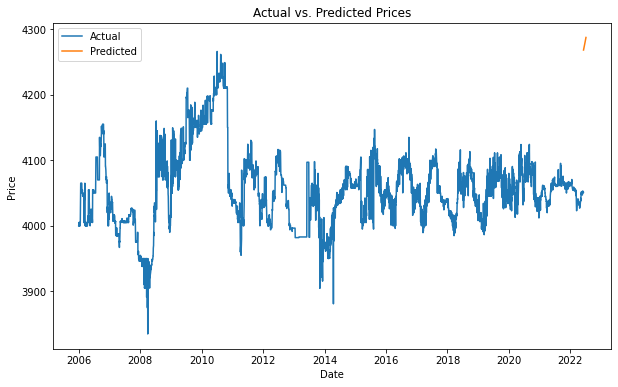

In [46]:
# Plot the actual and predicted prices
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Price'], label='Actual')
plt.plot(predicted_dates, predicted_prices, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.show()

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import GridSearchCV

# Step 2: Define the hyperparameters to tune
parameters = {
    'epochs': [10, 20, 30],
    'batch_size': [16, 32, 64],
    'learning_rate': [0.001, 0.0001, 0.00001],
    'hidden_layer_size': [128, 256, 512],
    'activation': ['tanh', 'relu', 'sigmoid']
}

# Create a grid search object
grid_search = GridSearchCV(
    model,
    parameters,
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search object to the data
grid_search.fit(train_data, y_train)

# Print the best parameters
print(grid_search.best_params_)


TypeError: If no scoring is specified, the estimator passed should have a 'score' method. The estimator <keras.engine.sequential.Sequential object at 0x0000020AB8A8A320> does not.